# Sentiment Analysis with Natural Language Processing and Machine Learning 
##### Written by: Jordan Fortney

## Introduction
Language is one of the fundamental pillars of our society so it comes as no surprise that it can be an incredibly powerful form of data if it is processed and analyzed effectively. The ability to analyse every book in a library or every political article from the past decade is something that is only efficiently possible using computer science and opens up many powerful avenues to augment a decision making process. From product reviews to social media posts to novels and articles the mediums in which our language can be conveyed is diverse and complex. This diversity and complexity, along with the inherent nuances innately found in how we communicate, requires special techniques and strategies to be applied before it can be used to train machine learning models and make meaningful predictions. This porject will explore those strategies and apply them to various types of machne learning models. 

A common use for natural language processing (NLP) is to determine the overall sentiment regarding a specific subject. This subject could be anything from a product review to someone's tweet history. This project will outline those processing steps, test and compare various optimized machine learning models, and build a production ready tool that predicts the ***positive and negative*** sentiment of product reviews and output lists with those predictions. The focus of this porject will be to achieve an accuracy and recall of 80% or higher.

## Project Set-up and Data Overview

### Packages:
A relatively standard suite of packages are used for this project. Of note are the CountVectrorizer and TfidfVectorizer packages from [sklearn](https://scikit-learn.org/stable/about.html#citing-scikit-learn) which are used to tokenize text and is an intergral part of NLP.

In [33]:
# standard python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os.path
import time
from datetime import date

# nlp tokenizers and support packages
import nltk
import string
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# machine Learning models and tools 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

# metrics used to determine the accuracy of the models and compare them
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# ignore some warnings that can be unsightly
import warnings
warnings.filterwarnings('ignore')

### Data Upload and Overview
The primary dataset used for this project is composed of text from Twitter, Yelp, and Mobile Reviews, it was downloaded from [Kaggle](https://www.kaggle.com/akgeni/generic-sentiment-multidomain-sentiment-dataset). The dataset has 3 features: sentiment (positive, negative, or neutral), text, and a numeric label (0, 1, 2). The sentiment and label feature are technically redundant as we can get the same information by only have one of the two. There are 50,000 records that will be used for the training and validation of the model while 10,000 records within a seperate dataset will be used for testing the production tool.

Upon inspection of the data it is evident that it is not of the highest quality. There seems to be many spelling and grammatical errors along with a decent amount of slang. This may cause issues later one when trying to fit new test data as there may not be as many matching tokens as there would be with more standardized data. But the reality of the real world is that text data is rarely perfect and will vary with geolocation, vocabulary, and the general proficiency with the English language of the reviewer.

In [34]:
# load csv from local repository
sentTrain = pd.read_csv('generic_sentiment_dataset_50k.csv')
# display the dataframe
display(sentTrain.head())
# dataframe shape (50000 rows, 3 features)
display(sentTrain.shape)

,sentiment,text,label
0,positive,good mobile. battery is 5000 mah is very big. ...,2
1,positive,Overall in hand ecpirience is quite good matt ...,2
2,positive,"1. Superb Camera,\r\n2. No lag\r\n3. This is m...",2
3,positive,Bigger size of application names doesn't allow...,2
4,negative,Just a hype of stock android which is not flaw...,0


(50000, 3)

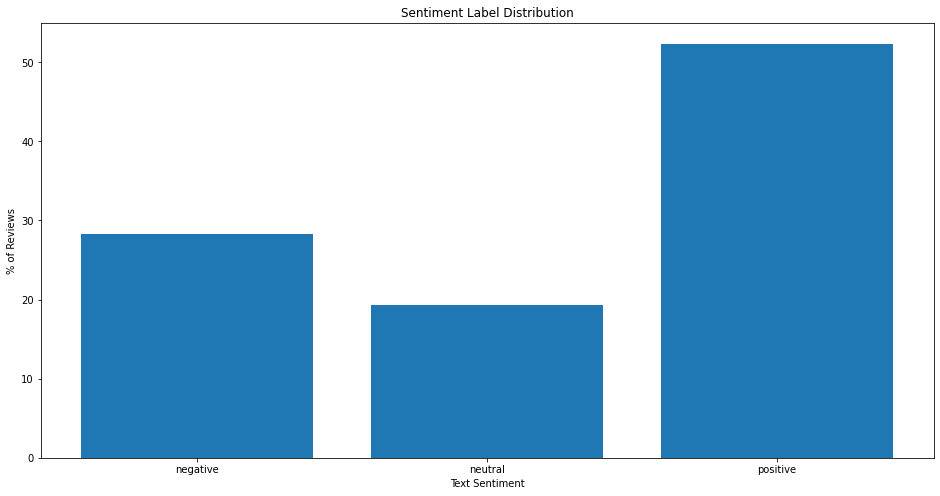

In [35]:
# get the unique values and their counts for the dataset
values, counts = np.unique(sentTrain['sentiment'], return_counts=True)
# normalize the counts to percentages
normalized_counts = counts/counts.sum()

# plot the unique sentiments and their normalized counts
plt.figure(figsize = (16,8))
plt.bar(values, normalized_counts*100)
plt.xlabel('Text Sentiment')
plt.xticks([0,1,2])
plt.ylabel('% of Reviews')
plt.title("Sentiment Label Distribution")
plt.show()

The graph above clearly shows that the distribution of the labels is unbalanced but not drastically so with a 50/30/20 split, this is not uncommon to see within a multi-class dataset. The degree in which the data is skewed does not require us to re-sample the data to ensure proper model training but SMOTE re-sampling would be the suggested method if if we wanted to go that route. Later in the project we will explore different data groupings but the project will focus on training the model with 3 potential classes. 

### Tokenization:

Tokenization is the process of slicing up a body of text and transforming it into a format that is more digestible by machine learning models. It achieves this by creating 'tokens', removing transitional words, and ensuring common words are in a uniform tense structure. The tokens are slices of a sentance, which can be 1 word or more depending on the tokenizer's parameters, that are then turned into individual features in place of the original body of text; this is the main function of the tokenizer. Another function of the tokenizer is to remove punctuation and transitional words (stop words) from the dataset such as: this, a, and, an. These words are removed because they offer no predictive information to the model and are also likely to be found in all potential classes. For example the phrases "This is good" or "This is bad" provides the same amount of useful information as "good" or "bad". Lastly the tokenizer will use stemming to ensure words are in a common root form. Words like: "worked", "works", and "working" will all be changed to "work" and aggregated.

The end product of tokenization is the creation one feature for each token and an associated value within each feature corresponding to what tokens are present in each record. There are two main forms for this value to take that depends on which of the two main tokenizers are used. The Count Vecotrizer (bag of words) method returns a value equal to the count of each token within the specific record. The TF-IDF Vectorizer returns a value equal to the normalized weight of each token within the record which represents how relevant that token is within the record. Different models will perform differently using either tokenizer so we will use both on our dataset and test both within each model.


### Custom Tokenizer:
This project uses a custom tokenizer that I was given during on of my courses that removes all the common English stop words and performs stemming. We're using this as a parameter within the typical tokenizers because they do not include stemming.

In [36]:
# provided to me during my Data Science diploma program

ENGLISH_STOP_WORDS = stopwords.words('english')

def customTokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    stemmer = nltk.stem.PorterStemmer()
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [37]:
# function to graph the frequencyt of each gram 

def plot_most_frequent(words, word_counts, top=20):
    # create a temp dataframe containing the words and their counts from the vectorizer
    wordsDF = pd.DataFrame({"token": words, "count": word_counts})
    wordsDF = wordsDF.sort_values(by = 'count', ascending = False).head(top)
    
    # plot the frequency of each gram and sort it in descending order
    plt.figure(figsize=(16,8))
    plt.bar(wordsDF['token'], wordsDF['count'])
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()

In [38]:
# splitting the text and labels into their own variables
X = sentTrain['text']
y = sentTrain['label']

### Count Vectorizer:
The text feature from our dataset will be run through the Count Vectorizer and a new dataset will be created to display the tokenization. Through its parameters the vectorizer will also exclude any token that does not occur more than 75 times (min_df = 75) and will create tokens consisting of 1 to 3 consecutive words (ngram_range = (1,3)).

In [40]:
# compile the tokenizer
sentWordsVec = CountVectorizer(min_df = 75, 
                                tokenizer = customTokenizer,
                                strip_accents = 'ascii',
                                ngram_range = (1,3))
# fit the text feature from the original dataset to the count vectorizer
sentWordsVec.fit(X)
# transform the text feature from the original dataset
X_Vec = sentWordsVec.transform(X)

In [41]:
# build a new dataframe for the count vectorized tokens
VecDF = pd.DataFrame(columns = sentWordsVec.get_feature_names(), data = X_Vec.toarray())
VecDF['label'] = y
display(VecDF)

,\r\n\r\ni,\r\n\r\nthe,0,1,1 day,1 month,10,10 day,100,10000,...,year,yelp,yesterday,yet,youll,your,youtub,yummi,zoom,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


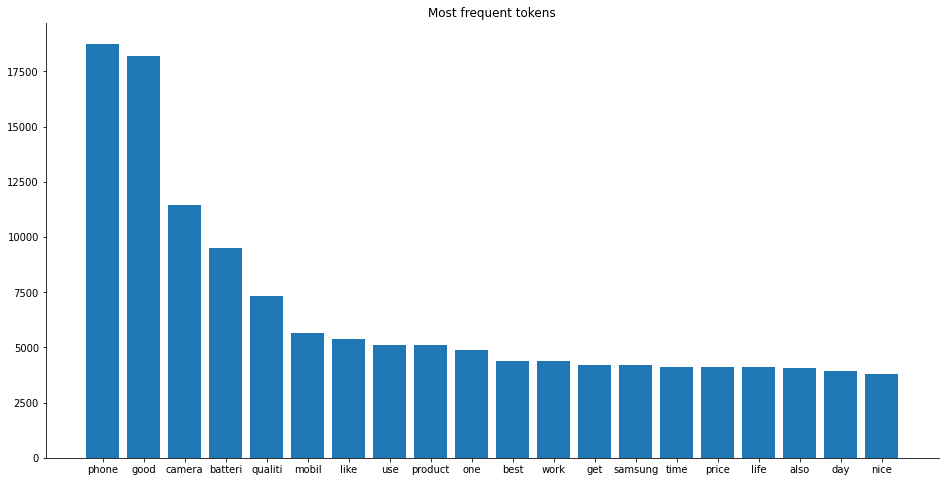

In [42]:
# sum the counts for each token
wordCountsVec = X_Vec.toarray().sum(axis=0)
# get the names of each token
wordsVec = sentWordsVec.get_feature_names()

# plot the counts and display the top 20 most frequent tokens
plot_most_frequent(wordsVec, wordCountsVec)

Based on the graph above it is very evident that the tokens: "phone" and "good" are prevalent throughout the dataset. The original dataset is based on data from Twitter, Yelp, and mobile reviews and with mobile reviews being the most specific of those three categories it is no surprise that the "phone" token is so prevalent.

### TF-IDF Vectorizer:
The text feature from our dataset will be run through the TF-IDF and a new dataset will be created to display the tokenization. Through its parameters the vectorizer will also exclude any token that does not occur more than 75 times (min_df = 75) and will create tokens consisting of 1 to 3 consecutive words (ngram_range = (1,3)).

In [43]:
# compile the tokenizer
sentWordsIdf = TfidfVectorizer(min_df = 75, 
                                tokenizer = customTokenizer,
                                ngram_range = (1,3),
                                strip_accents = 'ascii')

# fit the text feature from the original dataset to the tf-idf vectorizer    
sentWordsIdf.fit(X)
# transform the text feature from the original dataset
X_Idf = sentWordsIdf.transform(X)

In [44]:
# build a new dataframe for the tf-idf vectorized tokens
IdfDF = pd.DataFrame(columns = sentWordsIdf.get_feature_names(), data = X_Idf.toarray())
IdfDF['label'] = y
display(IdfDF)

,\r\n\r\ni,\r\n\r\nthe,0,1,1 day,1 month,10,10 day,100,10000,...,year,yelp,yesterday,yet,youll,your,youtub,yummi,zoom,label
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.252649,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
49996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
49997,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
49998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


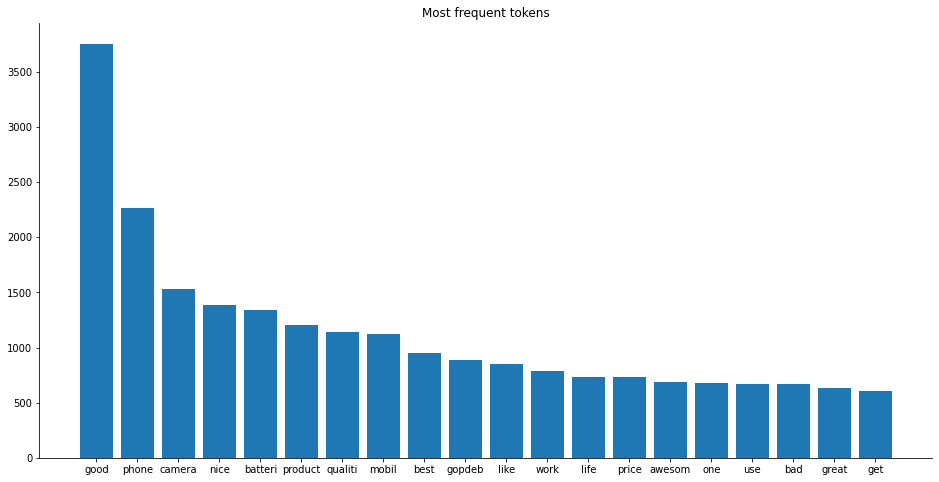

In [45]:
# sum the counts for each token
wordCountsIdf = X_Idf.toarray().sum(axis=0)
# get the names of each token
wordsIdf = sentWordsIdf.get_feature_names()

# plot the summed weights and display the top 20 most frequent tokens
plot_most_frequent(wordsIdf, wordCountsIdf)

The only significantlt noticable change between the tf-idf vectorized tokens and those of the count vectorizer is that the "good" token now dwarfs that of the "phone" token where they were almost equal before. This shows that although "phone" occurs more often, "good" holds much more weight within the records it doesn't occur in. Another notable difference is that "bad" comes into the top 20 tokens which should play a role in determining the sentiment of the record. 

## Machine Learning Models

Now that we have two sets of tokens we will build and optimize 5 different models for each vectorizer to determine which combonation will result in the best predictor. The models that will be tested are:

    * Logistic Regression
    * Support Vector Machine (SVC)
    * K-Nearest Neighbors
    * Decision Tree
    * Multinomial Naive Bayes

#### Genreal Process:
5 different models will be tested with 2 vectorizers each to determine the optimal pairing out of a possible 10. The general process for each pair will be to optimize the model using hyper-parameters separately for each vectorizer. Once the hyper-parameters are dialed in the scores will be used temporarily to compare the two. Later in the project we will use cross-validation to get a better picture of the results and decide which model/vectorizer pair is best. Throughout the project *Vec* will be used to denote count vectorized data/models and *Idf* will be used to denote TF-Idf vectorized data/models.

### Logistic Regression:
The hyperparameter that will be optimized for the logistic regression is the c-value which controls the strength of the regularization.

In [46]:
# setting independent and dependent Vec variables
XVec = VecDF.iloc[:, :-1]
yVec = VecDF.iloc[:,-1]
print(f"Shapes: {XVec.shape, yVec.shape}")

Shapes: ((50000, 1647), (50000,))


In [47]:
# splitting the Vec data into traina nd validation splits
X_trainVec, X_valVec, y_trainVec, y_valVec = train_test_split(XVec, yVec, test_size=0.33, random_state=12)
print(f"Train Shapes: {X_trainVec.shape, y_trainVec.shape}")
print(f"Val Shapes: {X_valVec.shape, y_valVec.shape}")

Train Shapes: ((33500, 1647), (33500,))
Val Shapes: ((16500, 1647), (16500,))


In [48]:
# empty list for score results
valScores = []
trainScores = []
cVals = []
# range od c -values to loop through
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores.joblib') & os.path.exists('preRunModels/trainScores.joblib') & os.path.exists('preRunModels/cVals.joblib')):
    valScores = joblib.load('preRunModels/valScores.joblib')
    trainScores = joblib.load('preRunModels/trainScores.joblib')
    cVals = joblib.load('preRunModels/cVals.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    for c in C_range:
        # for each c-value fit and train the model
        my_logreg = LogisticRegression(solver='lbfgs', C = c, random_state = 12)
        my_logreg.fit(X_trainVec, y_trainVec)

        # score the model on the train and validation and append to lists
        trainScores.append(my_logreg.score(X_trainVec, y_trainVec))
        valScores.append(my_logreg.score(X_valVec, y_valVec))
        cVals.append(c)
        
    # Save the model result lists for loading in the futrure
    joblib.dump(valScores, 'preRunModels/valScores.joblib')
    joblib.dump(trainScores, 'preRunModels/trainScores.joblib')
    joblib.dump(cVals, 'preRunModels/cVals.joblib')
        
# save c-value with the highest validation score
bestCValVec = cVals[np.argmax(valScores)]

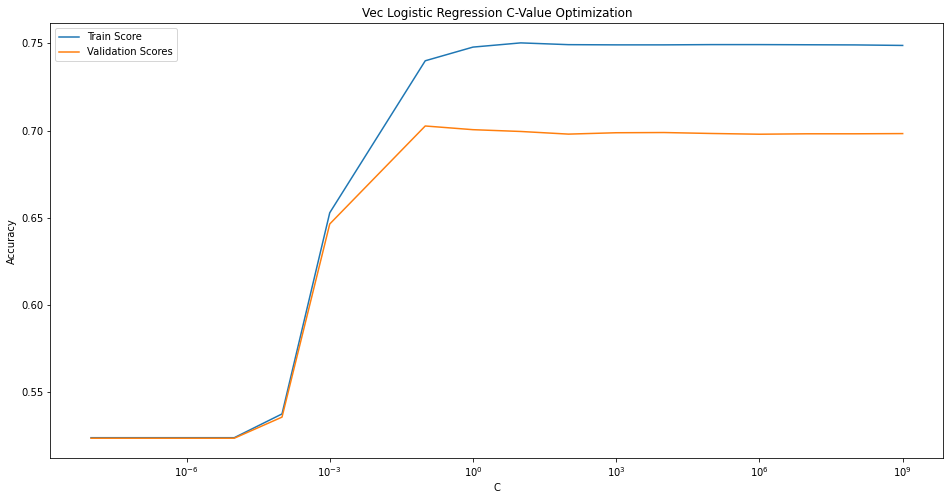

The c-calue with the highest validation score is 0.1


In [49]:
# plot the train and validation scores against the c-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(cVals, trainScores,label="Train Score")
plt.plot(cVals, valScores,label="Validation Scores")
plt.title('Vec Logistic Regression C-Value Optimization')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-calue with the highest validation score is {bestCValVec}")

In [50]:
# setting independent and dependent Idf variables
XIdf = IdfDF.iloc[:, :-1]
yIdf = IdfDF.iloc[:,-1]
print(f"Shapes: {XIdf.shape, yIdf.shape}")

Shapes: ((50000, 1647), (50000,))


In [51]:
# splitting the Idf data into train and validation splits
X_trainIdf, X_valIdf, y_trainIdf, y_valIdf = train_test_split(XIdf, yIdf, test_size=0.33, random_state=12)
print(f"Train Shapes: {X_trainIdf.shape, y_trainIdf.shape}")
print(f"Val Shapes: {X_valIdf.shape, y_valIdf.shape}")

Train Shapes: ((33500, 1647), (33500,))
Val Shapes: ((16500, 1647), (16500,))


In [52]:
# empty list for score results
valScores2 = []
trainScores2 = []
cVals2 = []
# range od c -values to loop through
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores2.joblib') & os.path.exists('preRunModels/trainScores2.joblib') & os.path.exists('preRunModels/cVals2.joblib')):
    valScores2 = joblib.load('preRunModels/valScores2.joblib')
    trainScores2 = joblib.load('preRunModels/trainScores2.joblib')
    cVals2 = joblib.load('preRunModels/cVals2.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    for c in C_range:
        # for each c-value fit and train the model
        my_logreg = LogisticRegression(solver='lbfgs', C = c, random_state = 12)
        my_logreg.fit(X_trainIdf, y_trainIdf)

        # score the model on the train and validation and append to lists
        trainScores2.append(my_logreg.score(X_trainIdf, y_trainIdf))
        valScores2.append(my_logreg.score(X_valIdf, y_valIdf))
        cVals2.append(c)
        
    # Save the model result lists for loading in the futrure
    joblib.dump(valScores2, 'preRunModels/valScores2.joblib')
    joblib.dump(trainScores2, 'preRunModels/trainScores2.joblib')
    joblib.dump(cVals2, 'preRunModels/cVals2.joblib')
        
# save c-value with the highest validation score
bestCValIdf = cVals2[np.argmax(valScores2)]

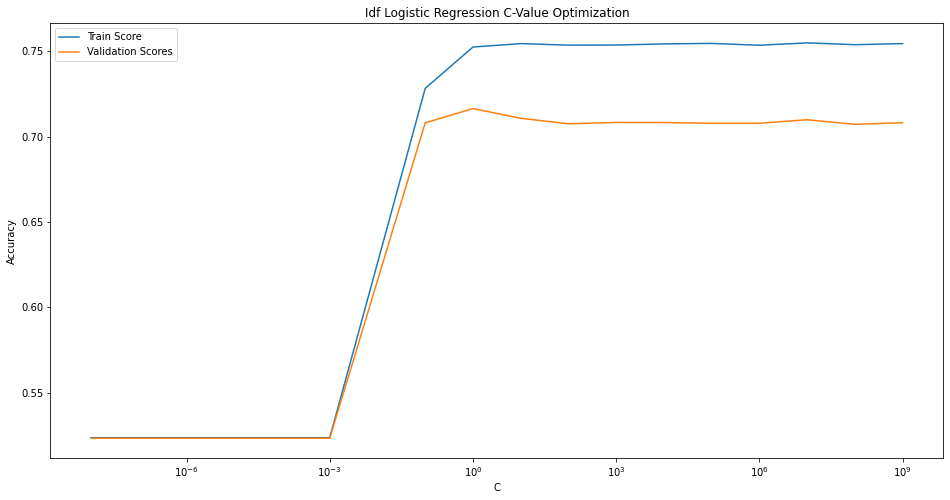

The c-calue with the highest validation score is 1.0


In [53]:
# plot the train and validation scores against the c-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(cVals2, trainScores2, label="Train Score")
plt.plot(cVals2, valScores2, label="Validation Scores")
plt.title('Idf Logistic Regression C-Value Optimization')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-calue with the highest validation score is {bestCValIdf}")

In [54]:
# build model with best vec c-value
logitVec = LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12)
# if a pre-run model exisits then load it
if (os.path.exists('preRunModels/logitVec.joblib')):
    logitVec = joblib.load('preRunModels/logitVec.joblib')
    print("Pre-run model will be loaded")
else:
    # fit the model with the train vec data
    logitVec = logitVec.fit(X_trainVec, y_trainVec)
    joblib.dump(logitVec, 'preRunModels/logitVec.joblib')

# score and print the train and validation results with the optimized model
print(f"Logestical Regression Vec Train: {logitVec.score(X_trainVec, y_trainVec)}")
print(f"Logestical Regression Vec Validation: {logitVec.score(X_valVec, y_valVec)}")
print("")

# build model with best idf c-vlaue
logitIdf = LogisticRegression(solver='lbfgs', C = bestCValIdf, random_state = 12)
# if a pre-run model exists then load it
if (os.path.exists('preRunModels/logitIdf.joblib')):
    logitIdf = joblib.load('preRunModels/logitIdf.joblib')
    print("Pre-run model will be loaded")
else:
    # fir the model with the train idf data
    logitIdf = logitIdf.fit(X_trainIdf, y_trainIdf)
    joblib.dump(logitIdf, 'preRunModels/logitIdf.joblib')

# score and print the train and validation results with the optimized model
print(f"Logestical Regression IDF Train: {logitIdf.score(X_trainIdf, y_trainIdf)}")
print(f"Logestical Regression IDF Validation: {logitIdf.score(X_valIdf, y_valIdf)}")

Logestical Regression Vec Train: 0.7400298507462687
Logestical Regression Vec Validation: 0.7026060606060606

Logestical Regression IDF Train: 0.7523880597014926
Logestical Regression IDF Validation: 0.7163636363636363


The TF-Idf vectorized data was able to train a superior model by ~2%. For a linear model performing multiclassification with a score of ~75% is a decent result but we'll see how it holds up during cross-validation and how it compares to other models. The train and validation scores are also within a resonable range and therefore we're not concerned with a large amount of overfitting. 

### Support Vector Machine (SVC)
The hyperparameter for the SVC model that will be optimized will also be the c-value which controls the strength of the regularization. We are using a much narrower range of c-values for this model because of the increased run time associated with the SVC model.

In [55]:
# empty list for score results
valScores3 = []
trainScores3 = []
cVals3 = []
# range od c -values to loop through
C_range = np.array([0.01,0.1,1,10,100])

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores3.joblib') & os.path.exists('preRunModels/trainScores3.joblib') & os.path.exists('preRunModels/cVals3.joblib')):
    valScores3 = joblib.load('preRunModels/valScores3.joblib')
    trainScores3 = joblib.load('preRunModels/trainScores3.joblib')
    cVals3 = joblib.load('preRunModels/cVals3.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    for c in C_range:
        # for each c-value fit and train the model
        svcVec = SVC(C = c, random_state = 12)
        svcVec.fit(X_trainVec, y_trainVec)

        # score the model on the train and validation and append to lists
        trainScores3.append(svcVec.score(X_trainVec, y_trainVec))
        valScores3.append(svcVec.score(X_valVec, y_valVec))
        cVals3.append(c)
        
    # save the model result lists for loading in the futrure
    joblib.dump(valScores3, 'preRunModels/valScores3.joblib')
    joblib.dump(trainScores3, 'preRunModels/trainScores3.joblib')
    joblib.dump(cVals3, 'preRunModels/cVals3.joblib')
        
# save c-value with the highest validation score
bestCValVecSvc = cVals3[np.argmax(valScores3)]

Pre-run model will be loaded


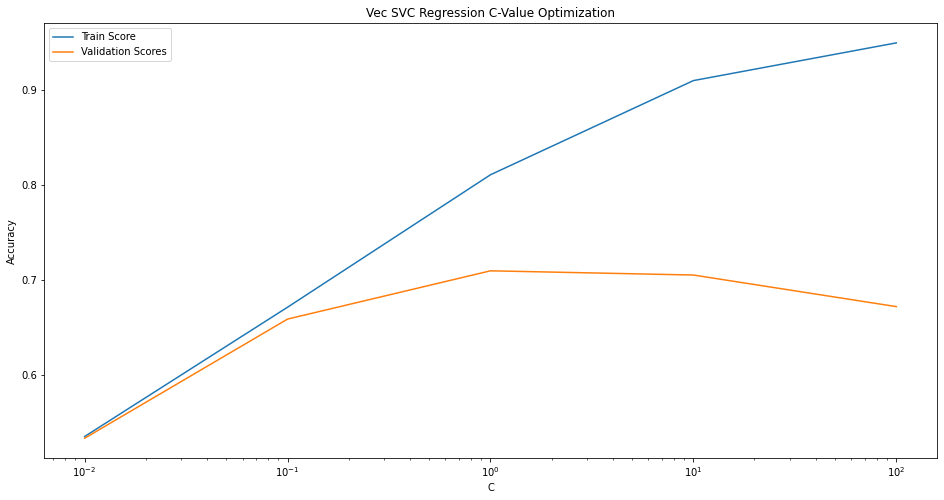

The c-value with the highest validation score is 1.0


In [56]:
# plot the train and validation scores against the c-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(cVals3, trainScores3, label="Train Score")
plt.plot(cVals3, valScores3, label="Validation Scores")
plt.title('Vec SVC Regression C-Value Optimization')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-value with the highest validation score is {bestCValVecSvc}")

In [57]:
# empty list for score results
valScores31 = []
trainScores31 = []
cVals31 = []
# range od c -values to loop through
C_range = np.array([0.01,0.1,1,10,100])

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/valScores31.joblib') & os.path.exists('preRunModels/trainScores31.joblib') & os.path.exists('preRunModels/cVals31.joblib')):
    valScores31 = joblib.load('preRunModels/valScores31.joblib')
    trainScores31 = joblib.load('preRunModels/trainScores31.joblib')
    cVals31 = joblib.load('preRunModels/cVals31.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    for c in C_range:
        # for each c-value fit and train the model
        svcIdf = SVC(C = c, random_state = 12)
        svcIdf.fit(X_trainIdf, y_trainIdf)

        # score the model on the train and validation and append to lists
        trainScores31.append(svcIdf.score(X_trainIdf, y_trainIdf))
        valScores31.append(svcIdf.score(X_valIdf, y_valIdf))
        cVals31.append(c)
        
    # save the model result lists for loading in the futrure
    joblib.dump(valScores31, 'preRunModels/valScores31.joblib')
    joblib.dump(trainScores31, 'preRunModels/trainScores31.joblib')
    joblib.dump(cVals31, 'preRunModels/cVals31.joblib')
        
# save c-value with the highest validation score
bestCValIdfSvc = cVals31[np.argmax(valScores31)]

Pre-run model will be loaded


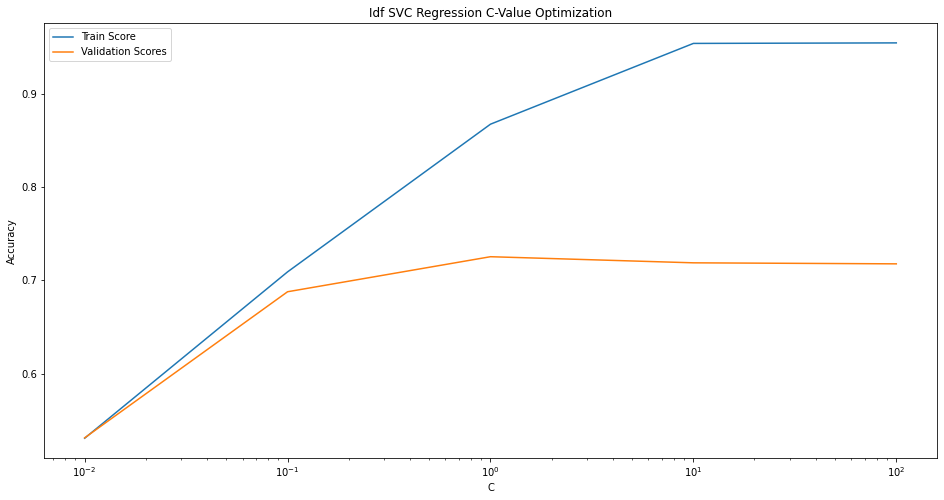

The c-value with the highest validation score is 1.0


In [58]:
# plot the train and validation scores against the c-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(cVals31, trainScores31, label="Train Score")
plt.plot(cVals31, valScores31, label="Validation Scores")
plt.title('Idf SVC Regression C-Value Optimization')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The c-value with the highest validation score is {bestCValIdfSvc}")

In [59]:
# build model with best vec c-value
svcVecNlp = SVC(C = bestCValVecSvc, random_state = 12)
# if pre-run model exists, load it
if os.path.exists('preRunModels/svcVecNlp.joblib'):
    svcVecNlp = joblib.load('preRunModels/svcVecNlp.joblib')
else:
    # fit svc vec model on train data
    svcVecNlp = svcVecNlp.fit(X_trainVec, y_trainVec)
    joblib.dump(svcVecNlp, 'preRunModels/svcVecNlp.joblib')

# if pre-run model exists, load it
if os.path.exists('preRunModels/svcVecNlpTrainScore.joblib'):
    svcVecNlpTrainScore = joblib.load('preRunModels/svcVecNlpTrainScore.joblib')
else:
    # score train svc vec data
    svcVecNlpTrainScore = svcVecNlp.score(X_trainVec, y_trainVec)
    joblib.dump(svcVecNlpTrainScore, 'preRunModels/svcVecNlpTrainScore.joblib')

# if pre-run model exists, load it
if os.path.exists('preRunModels/svcVecNlpValScore.joblib'):
    svcVecNlpValScore = joblib.load('preRunModels/svcVecNlpValScore.joblib')
else:
    # score val svc vec data
    svcVecNlpValScore = svcVecNlp.score(X_valVec, y_valVec)
    joblib.dump(svcVecNlpValScore, 'preRunModels/svcVecNlpValScore.joblib')

# print model scores for each vec data type
print(f"SVC Vec Train: {svcVecNlpTrainScore}")
print(f"SVC Vec Validation: {svcVecNlpValScore}",end= "\n")

print("")

# build model with best vec c-value
svcIdfNlp = SVC(C = bestCValIdfSvc, random_state = 12)
# if pre-run model exists, load it
if os.path.exists('preRunModels/svcIdfNlp.joblib'):
    svcIdfNlp = joblib.load('preRunModels/svcIdfNlp.joblib')
else:
    # score train svc idf data
    svcIdfNlp = svcIdfNlp.fit(X_trainIdf, y_trainIdf)
    joblib.dump(svcIdfNlp, 'preRunModels/svcIdfNlp.joblib')

# if pre-run model exists, load it
if os.path.exists('preRunModels/svcIdfNlpTrainScore.joblib'):
    svcIdfNlpTrainScore = joblib.load('preRunModels/svcIdfNlpTrainScore.joblib')
else:
    # score train svc idf data
    svcIdfNlpTrainScore = svcIdfNlp.score(X_trainIdf, y_trainIdf)
    joblib.dump(svcIdfNlpTrainScore, 'preRunModels/svcIdfNlpTrainScore.joblib')

# if pre-run model exists, load it
if os.path.exists('preRunModels/svcIdfNlpValScore.joblib'):
    svcIdfNlpValScore = joblib.load('preRunModels/svcIdfNlpValScore.joblib')
else:
    # score val svc idf data
    svcIdfNlpValScore = svcIdfNlp.score(X_valIdf, y_valIdf)
    joblib.dump(svcIdfNlpValScore, 'preRunModels/svcIdfNlpValScore.joblib')

# print model scores for each idf data type
print(f"SVC IDF Train: {svcIdfNlpTrainScore}")
print(f"SVC IDF Validation: {svcIdfNlpValScore}")

SVC Vec Train: 0.8105970149253732
SVC Vec Validation: 0.7097575757575758

SVC IDF Train: 0.8672238805970149
SVC IDF Validation: 0.7253333333333334


In [60]:
# manually set the best c-values to reduce the overfitting 
bestCValVecSvc = 0.1
bestCValIdfSvc = 0.1

These train scores are significantly higher than those from the logistic regression but the validation scores have not nearly changed by a similar degree. These results suggest an amount of over-fitting that would severely affect the confidence we have in it's ability to predict new data in the future. For this reason we'll manually set the best c-values to 0.1 from 1.0 for each of the vectorizers to reduce over-fitting as indicated by the performance graphs above. 

### K-Nearest Neighbours
The hyperparameter that will be optimized for the Knn model is the number of neighbours. This parameter controls how many of a point's nearest neighbours to consult when predicting it's class. The optimization is done in two steps for the sake of run time. First it is done with incremints of 100 and then it is done again with increments of 1 for a range surrounding the best result from the first step.

In [61]:
# empty lists to store iteration results
valScores4 = []
trainScores4 = []
K_values4 = []

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores4.joblib') & 
    os.path.exists('preRunModels/valScores4.joblib') & 
    os.path.exists('preRunModels/kValues4.joblib')):
    trainScores4 = joblib.load('preRunModels/trainScores4.joblib')
    valScores4 = joblib.load('preRunModels/valScores4.joblib')
    K_values4 = joblib.load('preRunModels/kValues4.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1, 10000, 100):

        # train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainVec, y_trainVec)

        # save model predictions and the relative number of neighbors to lists
        trainScores4.append(knnVec.score(X_trainVec, y_trainVec))
        valScores4.append(knnVec.score(X_valVec, y_valVec))
        K_values4.append(k)

    # save the model result lists for loading in the futrure
    joblib.dump(trainScores4, 'preRunModels/trainScores4.joblib')
    joblib.dump(valScores4, 'preRunModels/valScores4.joblib')
    joblib.dump(K_values4, 'preRunModels/kValues4.joblib')
    
# save best performing k-value
bestKValVecKnn = K_values4[np.argmax(valScores4)]

Pre-run model will be loaded


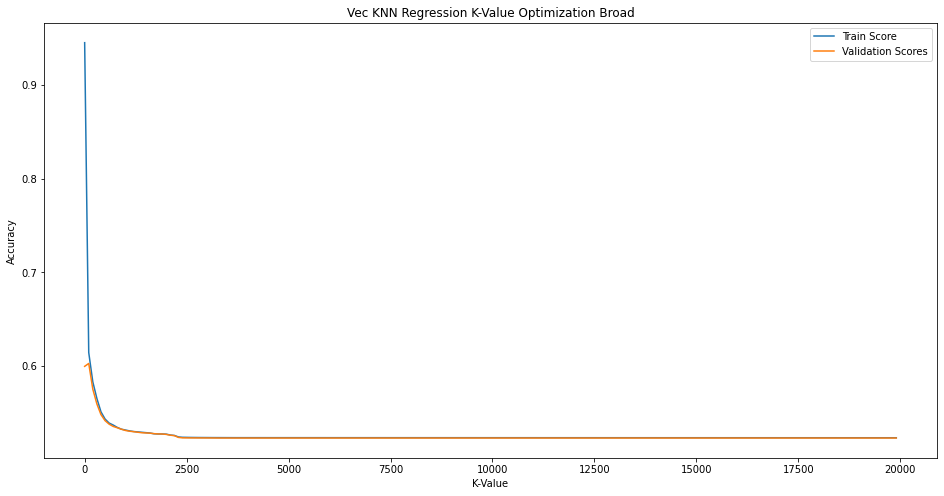

The K-Value with the highest validation score is 101


In [62]:
# plot the train and validation scores against the k-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(K_values4, trainScores4, label="Train Score")
plt.plot(K_values4, valScores4, label="Validation Scores")
plt.title('Vec KNN Regression K-Value Optimization Broad')
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The K-Value with the highest validation score is {bestKValVecKnn}")

In [63]:
# empty lists to store iteration results
valScores5 = []
trainScores5 = []
K_values5 = []

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores5.joblib') & 
    os.path.exists('preRunModels/valScores5.joblib') & 
    os.path.exists('preRunModels/k_Values5.joblib')):
    trainScores5 = joblib.load('preRunModels/trainScores5.joblib')
    valScores5 = joblib.load('preRunModels/valScores5.joblib')
    K_values5 = joblib.load('preRunModels/K_values5.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1,120):

        # train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainVec, y_trainVec)

        # save model predictions and the relative number of neighbors to lists
        trainScores5.append(knnVec.score(X_trainVec, y_trainVec))
        valScores5.append(knnVec.score(X_valVec, y_valVec))
        Kvalues5.append(k)
    
    # save the model result lists for loading in the futrure
    joblib.dump(trainScores5, 'preRunModels/trainScores5.joblib')
    joblib.dump(valScores5, 'preRunModels/valScores5.joblib')
    joblib.dump(K_values5, 'preRunModels/K_values5.joblib')
    
# save best performing k-value
bestKValVecKnn = K_values5[np.argmax(valScores5)]

Pre-run model will be loaded


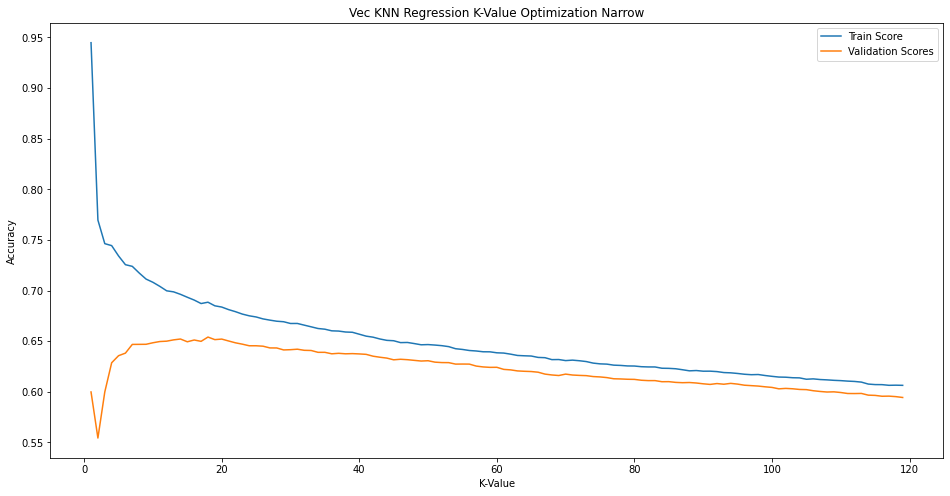

The K-Value with the highest validation score is 18


In [64]:
# plot the train and validation scores against the k-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(K_values5, trainScores5, label="Train Score")
plt.plot(K_values5, valScores5, label="Validation Scores")
plt.title('Vec KNN Regression K-Value Optimization Narrow')
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The K-Value with the highest validation score is {bestKValVecKnn}")

In [65]:
# empty lists to store iteration results
trainScores41 = []
valScores41 = []
K_values41 = []

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores41.joblib') & 
    os.path.exists('preRunModels/valScores41.joblib') & 
    os.path.exists('preRunModels/k_Values41.joblib')):
    trainScores41 = joblib.load('preRunModels/trainScores41.joblib')
    valScores41 = joblib.load('preRunModels/valScores41.joblib')
    K_values41 = joblib.load('preRunModels/k_Values41.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1, 10000, 100):

        # train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainIdf, y_trainIdf)

        # save model predictions and the relative number of neighbors to lists
        trainScores41.append(knnVec.score(X_trainIdf, y_trainIdf))
        valScores41.append(knnVec.score(X_valIdf, y_valIdf))
        K_values41.append(k)

    # save the model result lists for loading in the futrure
    joblib.dump(trainScores41, 'preRunModels/trainScores41.joblib')
    joblib.dump(valScores41, 'preRunModels/valScores41.joblib')
    joblib.dump(K_values41, 'preRunModels/k_Values41.joblib')
    
# save best performing k-value
bestKValIdfKnn = K_values41[np.argmax(valScores41)]

Pre-run model will be loaded


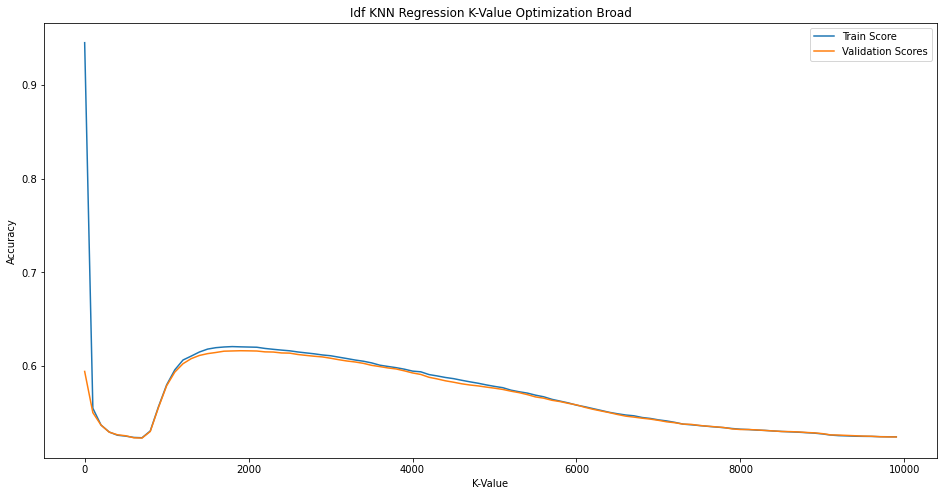

The K-Value with the highest validation score is 1901


In [66]:
# plot the train and validation scores against the k-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(K_values41, trainScores41, label="Train Score")
plt.plot(K_values41, valScores41, label="Validation Scores")
plt.title('Idf KNN Regression K-Value Optimization Broad')
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The K-Value with the highest validation score is {bestKValIdfKnn}")

In [67]:
# empty lists to store iteration results
trainScores51 = []
valScores51 = []
K_values51 = []

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores51.joblib') & 
    os.path.exists('preRunModels/valScores51.joblib') & 
    os.path.exists('preRunModels/K_values51.joblib')):
    trainScores51 = joblib.load('preRunModels/trainScores51.joblib')
    valScores51 = joblib.load('preRunModels/valScores51.joblib')
    K_values51 = joblib.load('preRunModels/K_values51.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1800, 2000):
        print(f"K={k}")
        # train and fit model with testing number of neighbors
        knnVec = KNeighborsClassifier(n_neighbors=k).fit(X_trainIdf, y_trainIdf)

        # save model predictions and the relative number of neighbors to lists
        trainScores51.append(knnVec.score(X_trainIdf, y_trainIdf))
        valScores51.append(knnVec.score(X_valIdf, y_valIdf))
        K_values51.append(k)

    # save the model result lists for loading in the futrure
    joblib.dump(trainScores51, 'preRunModels/trainScores51.joblib')
    joblib.dump(valScores51, 'preRunModels/valScores51.joblib')
    joblib.dump(K_values51, 'preRunModels/K_values51.joblib')
    
# save best performing k-value
bestKValIdfKnn = K_values51[np.argmax(valScores51)]

Pre-run model will be loaded


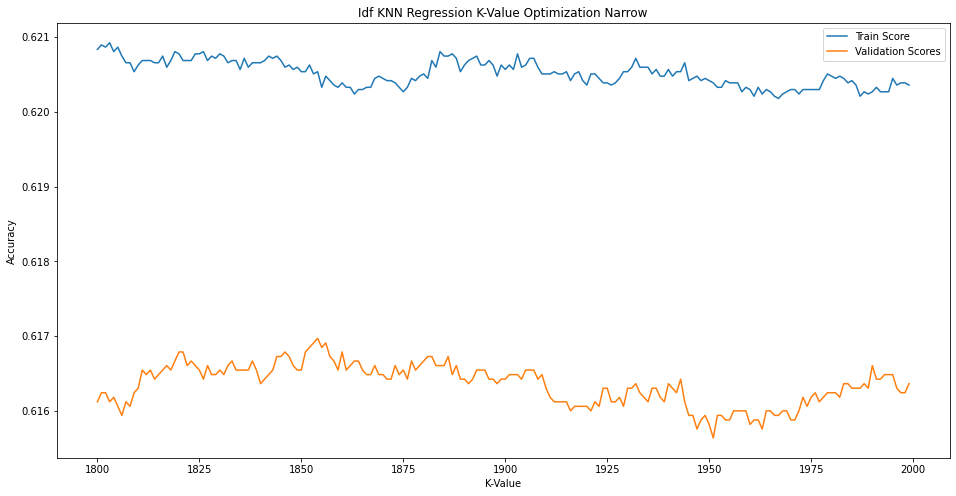

The K-Value with the highest validation score is 1854


In [68]:
# plot the train and validation scores against the k-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(K_values51, trainScores51, label="Train Score")
plt.plot(K_values51, valScores51, label="Validation Scores")
plt.title('Idf KNN Regression K-Value Optimization Narrow')
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The K-Value with the highest validation score is {bestKValIdfKnn}")

In [69]:
# compile and fit vec model with optimized hyperparameters
knnVecNlp = KNeighborsClassifier(n_neighbors=bestKValVecKnn).fit(X_trainVec, y_trainVec)
# score train data on vec model
svcVecNlpTrainScore = knnVecNlp.score(X_trainVec, y_trainVec)
# score train data on idf model
svcVecNlpValScore = knnVecNlp.score(X_valVec, y_valVec)

# print train and val scores
print(f"KNN Vec Train: {svcVecNlpTrainScore}")
print(f"KNN Vec Validation: {svcVecNlpValScore}")
print()

# compile and fit idf model with optimized hyperparameters
knnIdfNlp = KNeighborsClassifier(n_neighbors=bestKValIdfKnn).fit(X_trainIdf, y_trainIdf)
# score train data on idf model
svcIdfNlpTrainScore = knnIdfNlp.score(X_trainIdf, y_trainIdf)
# score val data on idf model
svcIdfNlpValScore = knnIdfNlp.score(X_valIdf, y_valIdf)

# print train and val scores
print(f"KNN IDF Train: {svcIdfNlpTrainScore}")
print(f"KNN IDF Validation: {svcIdfNlpValScore}")

KNN Vec Train: 0.6883582089552239
KNN Vec Validation: 0.6482424242424243

KNN IDF Train: 0.6205373134328358
KNN IDF Validation: 0.616969696969697


At this point the KNN models have performed the worst from a pure scoring stand point but they do seem to be overfitting the least. Overfitting is an important factor to consider and accuracy may be worth discounting if it means our model performs better on the test data.

### Decision Tree
Two hyperparameters will be optimized for the decision tree model: minimum samples and depth. Minimum samples repesents the minimum number of samples that need to fall under the same criteria needed to split an internal node. This controls how specific our branches ultimately become. The second hyperparameter is max depth which controls how many decisions a record can be exposed to, in other words, how many levels exist in the decision tree. We are testing for the best min-sample value first and then using that in our depth testing because max-depth is dependent on min-samples if set to none.

In [70]:
# range to loop through from 1-20000
minSamples = np.arange(1, 125)
# empty lists to store results for graphing
trainScores6 = []
valScores6 = []
min_value6 = []

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores6.joblib') & 
    os.path.exists('preRunModels/valScores6.joblib') & 
    os.path.exists('preRunModels/min_value6.joblib')):
    trainScores6 = joblib.load('preRunModels/trainScores6.joblib')
    valScores6 = joblib.load('preRunModels/valScores6.joblib')
    min_value6 = joblib.load('preRunModels/min_value6.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    # for each number from 1-20000....
    for minS in minSamples:
        # compile, train, and fit the model and data
        dtVec = DecisionTreeClassifier(min_samples_leaf = minS, random_state=12)
        dtVec.fit(X_trainVec, y_trainVec)

        trainScores6.append(dtVec.score(X_trainVec, y_trainVec))
        valScores6.append(dtVec.score(X_valVec, y_valVec))
        min_value6.append(minS)
        
        # print the progress of the loop
        print(f"min samples={minS}")
        
    # save teh results lists to file
    joblib.dump(trainScores6, 'preRunModels/trainScores6.joblib')
    joblib.dump(valScores6, 'preRunModels/valScores6.joblib')
    joblib.dump(min_value6, 'preRunModels/min_value6.joblib')

# save best performing min-value
bestMinValVecDt = min_value6[np.argmax(valScores6)]

Pre-run model will be loaded


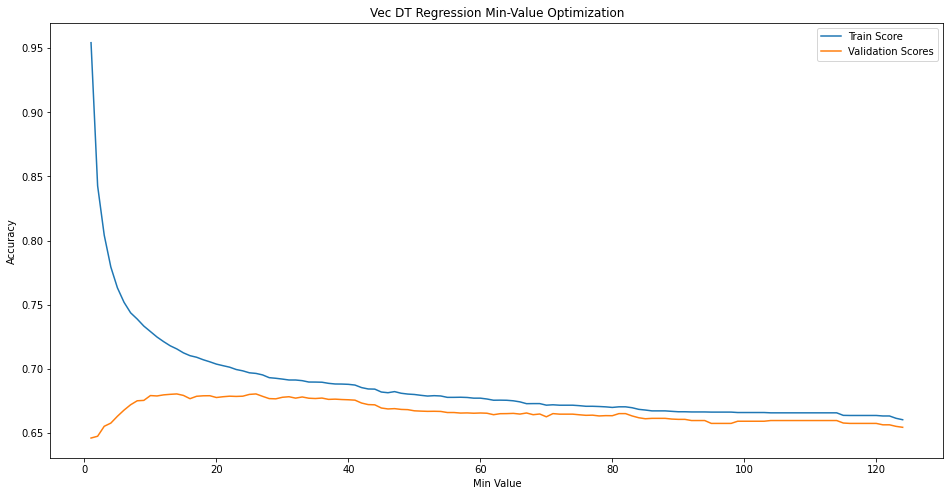

The Min Value with the highest validation score is 14


In [71]:
# plot the train and validation scores against the min-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(min_value6, trainScores6, label="Train Score")
plt.plot(min_value6, valScores6, label="Validation Scores")
plt.title('Vec DT Regression Min-Value Optimization')
plt.xlabel('Min Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The Min Value with the highest validation score is {bestMinValVecDt}")

In [72]:
# range to loop through from 1-20000
minSamples = np.arange(1, 200)
# empty lists to store results for graphing
trainScores61 = []
valScores61 = []
min_value61 = []

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores61.joblib') & 
    os.path.exists('preRunModels/valScores61.joblib') & 
    os.path.exists('preRunModels/min_value61.joblib')):
    trainScores61 = joblib.load('preRunModels/trainScores61.joblib')
    valScores61 = joblib.load('preRunModels/valScores61.joblib')
    min_value61 = joblib.load('preRunModels/min_value61.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    # for each number from 1-20000....
    for minS in minSamples:
        # compile, train, and fit the model and data
        dtIdf = DecisionTreeClassifier(min_samples_leaf = minS, random_state=12)
        dtIdf.fit(X_trainIdf, y_trainIdf)

        # score the model predictions
        trainScores61.append(dtIdf.score(X_trainIdf, y_trainIdf))
        valScores61.append(dtIdf.score(X_valIdf, y_valIdf))
        min_value61.append(minS)
        
        # print the progress of the loop
        print(f"min samples={minS}")
        
    # save teh results lists to file
    joblib.dump(trainScores61, 'preRunModels/trainScores61.joblib')
    joblib.dump(valScores61, 'preRunModels/valScores61.joblib')
    joblib.dump(min_value61, 'preRunModels/min_value61.joblib')
    
# save best performing min-value
bestMinValIdfDt = min_value61[np.argmax(valScores61)]

Pre-run model will be loaded


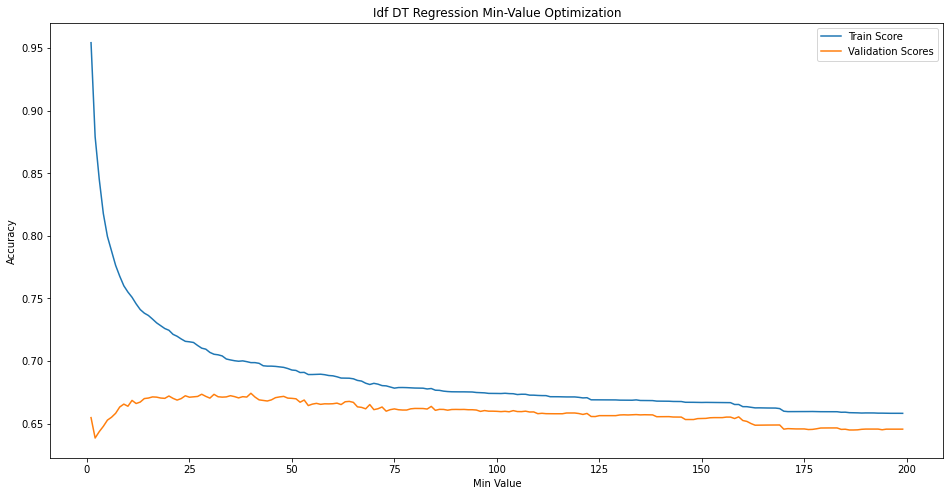

The Min Value with the highest validation score is 40


In [73]:
# plot the train and validation scores against the min-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(min_value61, trainScores61, label="Train Score")
plt.plot(min_value61, valScores61, label="Validation Scores")
plt.title('Idf DT Regression Min-Value Optimization')
plt.xlabel('Min Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The Min Value with the highest validation score is {bestMinValIdfDt}")

In [74]:
# range to loop through from 1-50
depths = np.arange(1, 201)
# empty lists to store results for graphing
trainScores7 = []
valScores7 = []
depth_value7 = []

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores7.joblib') & 
    os.path.exists('preRunModels/valScores7.joblib') & 
    os.path.exists('preRunModels/depth_value7.joblib')):
    trainScores7 = joblib.load('preRunModels/trainScores7.joblib')
    valScores7 = joblib.load('preRunModels/valScores7.joblib')
    depth_value7 = joblib.load('preRunModels/depth_value7.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    # for each number from 1-20000....
    for depth in depths:
        # compile, train, and fit the model and data
        dtVec = DecisionTreeClassifier(max_depth = depth, 
                                       min_samples_leaf = bestMinValVecDt, 
                                       random_state=12)
        dtVec.fit(X_trainVec, y_trainVec)

        # score the model predictions
        trainScores7.append(dtVec.score(X_trainVec, y_trainVec))
        valScores7.append(dtVec.score(X_valVec, y_valVec))
        depth_value7.append(depth)
        
        # print the progress of the loop
        print(f"depth={depth}")
        
    # save teh results lists to file
    joblib.dump(trainScores7, 'preRunModels/trainScores7.joblib')
    joblib.dump(valScores7, 'preRunModels/valScores7.joblib')
    joblib.dump(depth_value7, 'preRunModels/depth_value7.joblib')
    
# save the best depth value
bestDepthValVecDt = depth_value7[np.argmax(valScores7)]

Pre-run model will be loaded


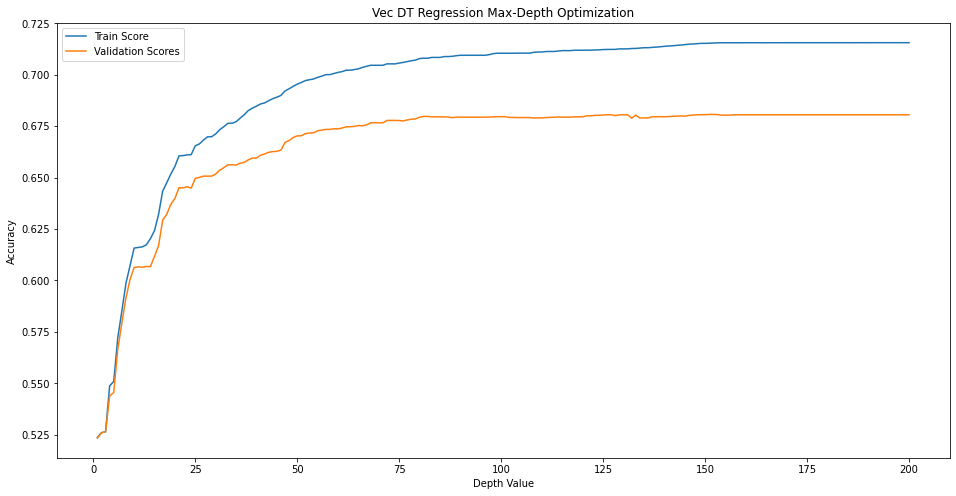

The Depth Value with the highest validation score is 151


In [75]:
# plot the train and validation scores against the min-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(depth_value7, trainScores7, label="Train Score")
plt.plot(depth_value7, valScores7, label="Validation Scores")
plt.title('Vec DT Regression Max-Depth Optimization')
plt.xlabel('Depth Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The Depth Value with the highest validation score is {bestDepthValVecDt}")

In [76]:
# range to loop through from 1-50
depths = np.arange(1, 201)
# empty lists to store results for graphing
trainScores71 = []
valScores71 = []
depth_value71 = []

# check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainScores71.joblib') & 
    os.path.exists('preRunModels/valScores71.joblib') & 
    os.path.exists('preRunModels/depth_value71.joblib')):
    trainScores71 = joblib.load('preRunModels/trainScores71.joblib')
    valScores71 = joblib.load('preRunModels/valScores71.joblib')
    depth_value71 = joblib.load('preRunModels/depth_value71.joblib')
    print("Pre-run model will be loaded")
# if no pre-run models exist...
else:
    # for each number from 1-20000....
    for depth in depths:
        # compile, train, and fit the model and data
        dtIdf = DecisionTreeClassifier(max_depth = depth, 
                                       min_samples_leaf = bestMinValIdfDt, 
                                       random_state=12)
        dtIdf.fit(X_trainIdf, y_trainIdf)

        # score the model predictions
        trainScores71.append(dtIdf.score(X_trainIdf, y_trainIdf))
        valScores71.append(dtIdf.score(X_valIdf, y_valIdf))
        depth_value71.append(depth)

    # save teh results lists to file
    joblib.dump(trainScores71, 'preRunModels/trainScores71.joblib')
    joblib.dump(valScores71, 'preRunModels/valScores71.joblib')
    joblib.dump(depth_value71, 'preRunModels/depth_value71.joblib')
    
# save best dpeth value
bestDepthValIdfDt = depth_value71[np.argmax(valScores71)]

Pre-run model will be loaded


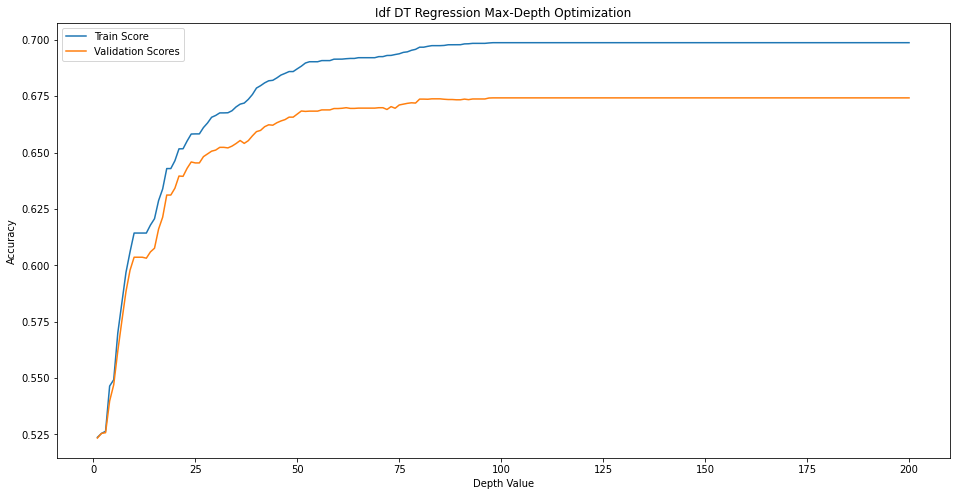

The Depth Value with the highest validation score is 98


In [77]:
# plot the train and validation scores against the min-values to inspect their performance for overfitting
plt.figure(figsize = (16,8))
plt.plot(depth_value71, trainScores71, label="Train Score")
plt.plot(depth_value71, valScores71, label="Validation Scores")
plt.title('Idf DT Regression Max-Depth Optimization')
plt.xlabel('Depth Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f"The Depth Value with the highest validation score is {bestDepthValIdfDt}")

In [78]:
# compile and fit vec data to dt model with optimized hyperparameters
dtVecNlp = DecisionTreeClassifier(max_depth = bestDepthValVecDt, min_samples_leaf = bestMinValVecDt, random_state=12).fit(X_trainVec, y_trainVec)
# score vec train data
dtVecTrain = dtVecNlp.score(X_trainVec, y_trainVec)
# score vec val data
dtVecVal = dtVecNlp.score(X_valVec, y_valVec)
# print vec scores
print(f"Decision Tree Vec Train: {dtVecTrain}")
print(f"Decision Tree Vec Validation: {dtVecVal}")

print()

# compile and fit idf data to dt model with optimized hyperparameters
dtIdfNlp = DecisionTreeClassifier(max_depth = bestDepthValIdfDt, min_samples_leaf = bestMinValIdfDt, random_state=12).fit(X_trainIdf, y_trainIdf)
# score idf train data
dtIdfTrain = dtIdfNlp.score(X_trainIdf, y_trainIdf)
# score idf val data
dtIdfVal = dtIdfNlp.score(X_valIdf, y_valIdf)
# print idf scores
print(f"Decision Tree IDF Train: {dtIdfTrain}")
print(f"Decision Tree IDF Validation: {dtIdfVal}")


Decision Tree Vec Train: 0.7148059701492537
Decision Tree Vec Validation: 0.6818181818181818

Decision Tree IDF Train: 0.6987164179104478
Decision Tree IDF Validation: 0.6742424242424242


With the decision tree models we have similarly reduced overfitting as the KNN models with imporved scores although they are not as high as the linear models.


### Multinominal Naive Bayes
The Naive Bayes model has limited parameters and none that require optimization. The data will be trained with the default settings.

In [79]:
# compile and fit nb model with vec train data
nbVecNlp = MultinomialNB().fit(X_trainVec, y_trainVec)
# score train vec data
nbVecTrain = nbVecNlp.score(X_trainVec, y_trainVec)
# score val vec data
nbVecVal = nbVecNlp.score(X_valVec, y_valVec)
# print scores
print(f"Multinominal Naive Bayes Vec Train: {nbVecTrain}")
print(f"Multinominal Naive Bayes Vec Validation: {nbVecVal}")

print()

# compile and fit nb model with idf train data
nbIdfNlp = MultinomialNB().fit(X_trainIdf, y_trainIdf)
# score train idf data
nbIdfTrain = nbIdfNlp.score(X_trainIdf, y_trainIdf)
# score val idf data
nbIdfVal = nbIdfNlp.score(X_valIdf, y_valIdf)
# print scores
print(f"Multinominal Naive Bayes Idf Train: {nbIdfTrain}")
print(f"Multinominal Naive Bayes Idf Validation: {nbIdfVal}")

Multinominal Naive Bayes Vec Train: 0.7074925373134329
Multinominal Naive Bayes Vec Validation: 0.6869090909090909

Multinominal Naive Bayes Idf Train: 0.7162686567164179
Multinominal Naive Bayes Idf Validation: 0.6947878787878788


Of all our tested models the multinomial Naive Bayes has the closest train and validation score (least overfitting) while also performing the best of the non-linear models. 

## Results and Testing

### Cross-validation and Model Comparisons: 

Now that we have baseline models that are optimized using hyper-parameters we can run a ten fold cross-validation on them with unsplit data to get an idea of how they perform when trained and validated on different data splits. This should give us a lot more confidence when choosing which model is superior to the others. 

In [80]:
# ensemble of models trained and optimized on the count vectorizer data
vecModels = [
    LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12),
    SVC(C = bestCValVecSvc, random_state = 12),
    KNeighborsClassifier(n_neighbors=bestKValVecKnn),
    DecisionTreeClassifier(max_depth = bestDepthValVecDt, min_samples_leaf = bestMinValVecDt, random_state=12),
    MultinomialNB()]

# ensemble of models trained and optimized on the TF-IDF vectorizer data
idfModels = [
    LogisticRegression(solver='lbfgs', C = bestCValIdf, random_state = 12),
    SVC(C = bestCValIdfSvc, random_state = 12),
    KNeighborsClassifier(n_neighbors=bestKValIdfKnn),
    DecisionTreeClassifier(max_depth = bestDepthValIdfDt, min_samples_leaf = bestMinValIdfDt, random_state=12),
    MultinomialNB()]

# number of cross-validation folds
CV = 10

# creating empty dataframe and lists to store cv results
cvIdfDF = pd.DataFrame(index=range(CV*len(idfModels)))
cvVecDF = pd.DataFrame(index=range(CV*len(vecModels)))
resultsIdf = []
resultsVec = []

# if pre-run models exist load them
if (os.path.exists('preRunModels/resultsIdf.joblib') & os.path.exists('preRunModels/accuraciesIdf.joblib')):
    accuraciesIdf = joblib.load('preRunModels/accuraciesIdf.joblib')
    resultsIdf = joblib.load('preRunModels/resultsIdf.joblib')
else:
    # loop through every model in our idf ensemble
    for model in idfModels:
        # save model type (name)
        modelName = model.__class__.__name__
        print(modelName)
        # save cv scores from 10 fold cross-validated models trained un raw data
        accuraciesIdf = cross_val_score(model, XIdf, yIdf, scoring = 'accuracy', cv = CV)
        # split the score results into their individual parameters
        for foldIndex, accuracy in enumerate(accuraciesIdf):
            resultsIdf.append((modelName, foldIndex, accuracy))

    # save results as pre-run models
    joblib.dump(accuraciesIdf, 'preRunModels/accuraciesIdf.joblib')
    joblib.dump(resultsIdf, 'preRunModels/resultsIdf.joblib')

# add results to our dataframe for inspection/display
cvIdfDF = pd.DataFrame(resultsIdf, columns = ['Model Name', 'Fold Index', 'Accuracy'])

# if pre-run models exist load them
if (os.path.exists('preRunModels/resultsVec.joblib') & os.path.exists('preRunModels/accuraciesVec.joblib')):
    accuraciesVec = joblib.load('preRunModels/accuraciesVec.joblib')
    resultsVec = joblib.load('preRunModels/resultsVec.joblib')
else:
    # loop through every model in our vec ensemble
    for model in vecModels:
        # save model type (name)
        modelName = model.__class__.__name__
        print(modelName)
        # save cv scores from 10 fold cross-validated models trained un raw data
        accuraciesVec = cross_val_score(model, XVec, yVec, scoring = 'accuracy', cv = CV)
        # split the score results into their individual parameters
        for foldIndex, accuracy in enumerate(accuraciesVec):
            resultsVec.append((modelName, foldIndex, accuracy))

    # save results as pre-run models
    joblib.dump(accuraciesVec, 'preRunModels/accuraciesVec.joblib')
    joblib.dump(resultsVec, 'preRunModels/resultsVec.joblib')

# add results to our dataframe for inspection/display
cvVecDF = pd.DataFrame(resultsVec, columns = ['Model Name', 'Fold Index', 'Accuracy'])


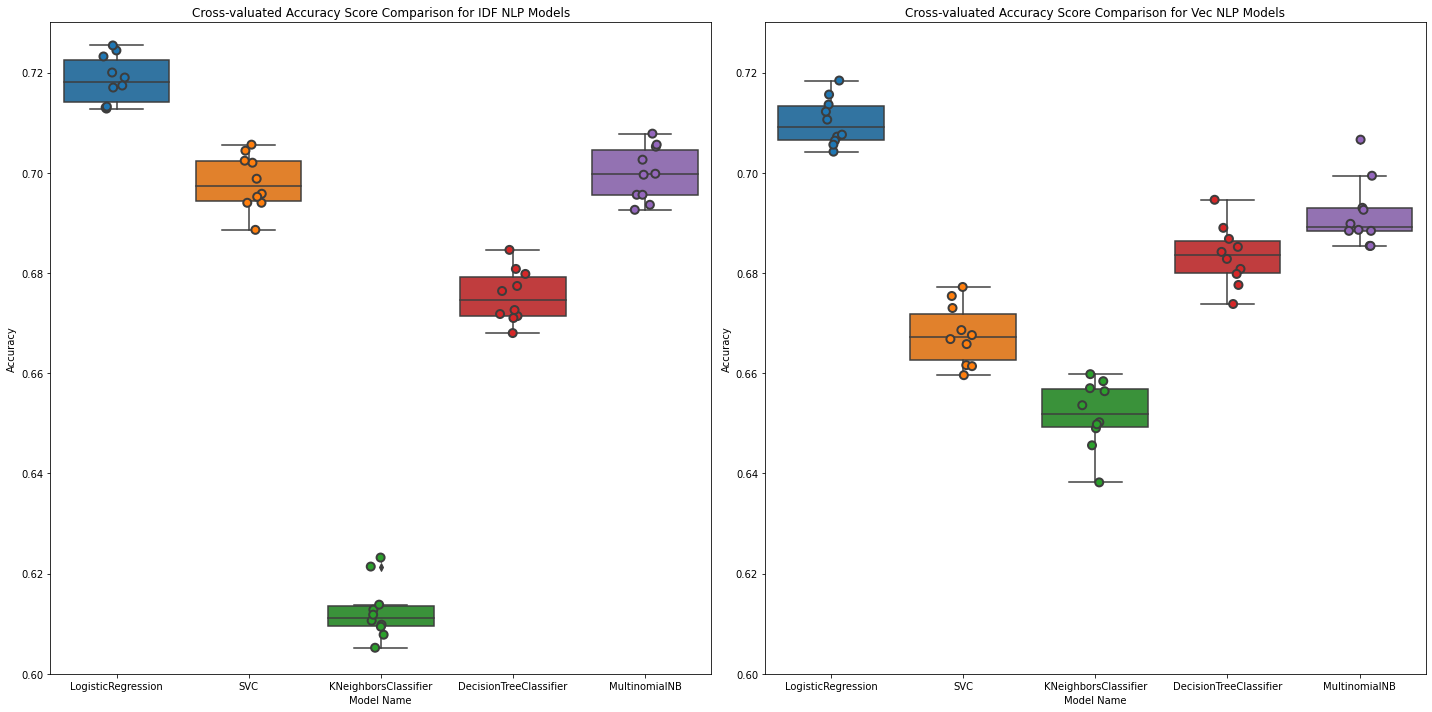

In [81]:
# create plot layout
plt.figure(figsize = (20,10), tight_layout = True)

# plot subplot with idf cv scores for each model
plt.subplot(1,2,1)
plt.title('Cross-valuated Accuracy Score Comparison for IDF NLP Models')
# set upper and lower limits to properly compare to vec models
plt.ylim([0.6,0.73])
sns.boxplot(x='Model Name', y='Accuracy', data = cvIdfDF)
sns.stripplot(x='Model Name', y='Accuracy', data = cvIdfDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

# plot subplot with vec scores for each model
plt.subplot(1,2,2)
plt.title('Cross-valuated Accuracy Score Comparison for Vec NLP Models')
# set upper and lower limits to properly compare to idf models
plt.ylim([0.6,0.73])
sns.boxplot(x='Model Name', y='Accuracy', data = cvVecDF)
sns.stripplot(x='Model Name', y='Accuracy', data = cvVecDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [82]:
modelMeansDF = cvIdfDF.groupby('Model Name', as_index = False).Accuracy.mean()
tempVecDF = cvVecDF.groupby('Model Name', as_index = False).Accuracy.mean()
modelMeansDF.merge(tempVecDF, 'inner', on = 'Model Name', suffixes = (' Mean IDF', ' Mean Vec'))

,Model Name,Accuracy Mean IDF,Accuracy Mean Vec
0,DecisionTreeClassifier,0.67538,0.68346
1,KNeighborsClassifier,0.61258,0.65180
2,LogisticRegression,0.71854,0.71014
3,MultinomialNB,0.69980,0.69176
4,SVC,0.69808,0.66770


The cross-validations support the rankings that were originally made for our models. The best performing model for both the Count Vectorizer and the TF-IDF was the logistic regression with a mean accuracy of 71.8%. The logistic regression was also one of the models that ran the quickest which is a nice bonus. The Multinomial Naive Bayes would be my second choice over the SVC as it seemed much more consistent between both toeknizers. This leads me to believe that it's less likely to react adversely when new data is applied to it in the future. The rankning within each group was consistent other than the SVC and Decision Tree results flipping positions. We'll examine the differences in tokenizer performance next. 

### Tokenizer Comparison:
The cross-validation graph was very useful for comparing models using the same tokenizer but we wanted to also compare the tokenizer using the same model. Although some data frame manipulation was required, this data will be the same as those in the graph above but organized different. We have also removed the hardcoded y-axis limits so the five graphs shouldn't be directly compared as displayed.  

In [83]:
# create new tokenizer dataframe and rename model name to tokenizer
tokenIdfDF = cvIdfDF.rename(columns = {'Model Name':'Tokenizer'})
tokenVecDF = cvVecDF.rename(columns = {'Model Name':'Tokenizer'})

# create dataframe for both logistic regressions models from token df
logDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'LogisticRegression']
logDF.loc[logDF['Tokenizer'] == 'LogisticRegression', 'Tokenizer'] = 'Idf'
logDF = pd.concat([logDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'LogisticRegression']])
logDF.loc[logDF['Tokenizer'] == 'LogisticRegression', 'Tokenizer'] = 'Vec'

# create dataframe for both svc models from token df
svcDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'SVC']
svcDF.loc[svcDF['Tokenizer'] == 'SVC', 'Tokenizer'] = 'Idf'
svcDF = pd.concat([svcDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'SVC']])
svcDF.loc[svcDF['Tokenizer'] == 'SVC', 'Tokenizer'] = 'Vec'

# create dataframe for both knn models from token df
knnDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'KNeighborsClassifier']
knnDF.loc[knnDF['Tokenizer'] == 'KNeighborsClassifier', 'Tokenizer'] = 'Idf'
knnDF = pd.concat([knnDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'KNeighborsClassifier']])
knnDF.loc[knnDF['Tokenizer'] == 'KNeighborsClassifier', 'Tokenizer'] = 'Vec'

# create dataframe for both decision tree models from token df
dtDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'DecisionTreeClassifier']
dtDF.loc[dtDF['Tokenizer'] == 'DecisionTreeClassifier', 'Tokenizer'] = 'Idf'
dtDF = pd.concat([dtDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'DecisionTreeClassifier']])
dtDF.loc[dtDF['Tokenizer'] == 'DecisionTreeClassifier', 'Tokenizer'] = 'Vec'

# create dataframe for both multinomial naive bayes models from token df
nbDF = tokenIdfDF[tokenIdfDF['Tokenizer'] == 'MultinomialNB']
nbDF.loc[nbDF['Tokenizer'] == 'MultinomialNB', 'Tokenizer'] = 'Idf'
nbDF = pd.concat([nbDF, tokenVecDF[tokenVecDF['Tokenizer'] == 'MultinomialNB']])
nbDF.loc[nbDF['Tokenizer'] == 'MultinomialNB', 'Tokenizer'] = 'Vec'

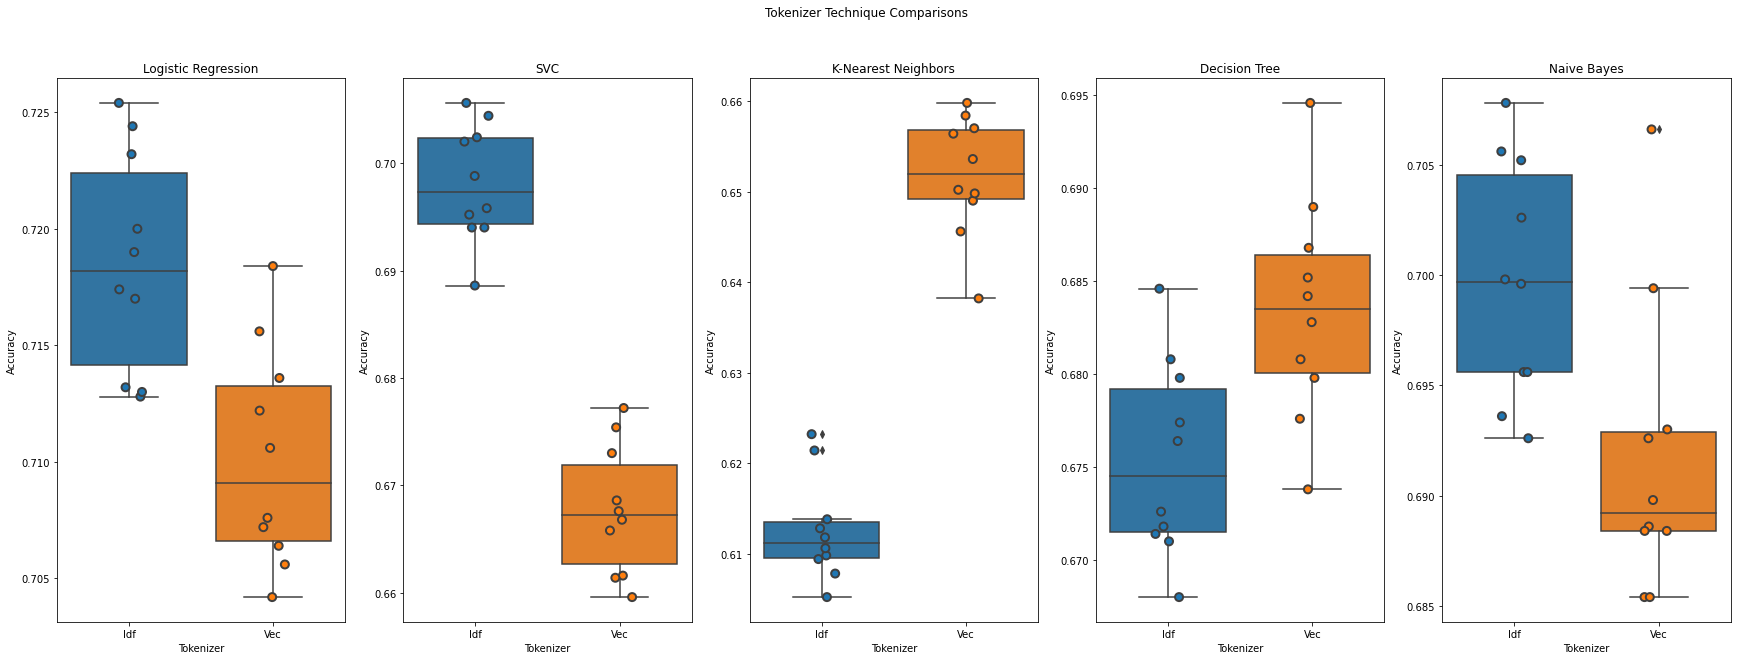

In [84]:
# overall figure features
plt.figure(figsize = (30,10),)
plt.suptitle('Tokenizer Technique Comparisons')

# subplot 1: logistic regression - vec vs. tf-idf
plt.subplot(1,5,1)
plt.title('Logistic Regression')
sns.boxplot(x='Tokenizer', y='Accuracy', data = logDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = logDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

# subplot 2: SVC - vec vs. tf-idf          
plt.subplot(1,5,2)
plt.title('SVC')
sns.boxplot(x='Tokenizer', y='Accuracy', data = svcDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = svcDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

# subplot 3: KNN - vec vs. tf-idf  
plt.subplot(1,5,3)
plt.title('K-Nearest Neighbors')
sns.boxplot(x='Tokenizer', y='Accuracy', data = knnDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = knnDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

# subplot 4: Decision Tree - vec vs. tf-idf 
plt.subplot(1,5,4)
plt.title('Decision Tree')
sns.boxplot(x='Tokenizer', y='Accuracy', data = dtDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = dtDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

# subplot 5: Multinomial Naive Bayes - vec vs. tf-idf 
plt.subplot(1,5,5)
plt.title('Naive Bayes')
sns.boxplot(x='Tokenizer', y='Accuracy', data = nbDF)
sns.stripplot(x='Tokenizer', y='Accuracy', data = nbDF, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

The TF-IDF performed better for the majority of the models with the KNN and Decision Tree being the outliers. The largest gap between tokenizers was found within the K-nearest neighbors model with a 4% improvement when the Count Vectorizer was used. The Logistic Regession, Decision Tree, and Naive Bayes models all had differences of ~0.8% and the results are likely not statistically different. Based on our results we determined that testing both types of tokenizers was a worthwhile endevour even though it would not have made a difference for the majority of the models. Had our data performed best with the SVC model (which it would have had we not manually changed the C-value to reduce overfitting) or the KNN model we would have benefitted substantially from choosing the correct toeknizer. 

### Classification Reports and Confusion Matrix

On top of the accuracy of the model it is also important to compare how our models perform from a precision and recall standpoint. The objective of the project is to correctly classify as many of the reviews as possible so recall will be the focus for determining the best model. Since the two logistic regressions performed the best up to this point we will focus on them to determine our final selection based on recall. 

In [85]:
logIdfPreds = logitIdf.predict(X_valIdf)
logVecPreds = logitVec.predict(X_valVec)

print(metrics.classification_report(y_valIdf, logIdfPreds, target_names = sentTrain['sentiment'].unique()))
print(metrics.classification_report(y_valVec, logVecPreds, target_names = sentTrain['sentiment'].unique()))

              precision    recall  f1-score   support

    positive       0.68      0.72      0.70      4649
    negative       0.47      0.25      0.33      3215
     neutral       0.78      0.89      0.83      8636

    accuracy                           0.72     16500
   macro avg       0.64      0.62      0.62     16500
weighted avg       0.69      0.72      0.69     16500

              precision    recall  f1-score   support

    positive       0.68      0.70      0.69      4649
    negative       0.44      0.18      0.26      3215
     neutral       0.75      0.90      0.82      8636

    accuracy                           0.70     16500
   macro avg       0.62      0.59      0.59     16500
weighted avg       0.67      0.70      0.67     16500



<Figure size 720x360 with 0 Axes>

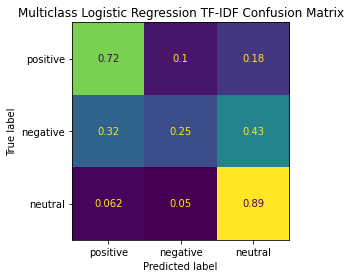

In [86]:
sentiments = ['positive','negative','neutral']
plt.figure(figsize = (10,5))
plot_confusion_matrix(logitIdf, X_valIdf ,y_valIdf, colorbar = False, display_labels = sentiments, normalize = 'true')
plt.title('Multiclass Logistic Regression TF-IDF Confusion Matrix')
plt.show()

Based on the results it is very obvious that our model is not capable of correctly determining which reviews are negative. In fact a negative prediction was the least likely outcome for a negative review to be classified as. Based on the data available we are not able to train a model confidently to classify these 3 classes. This is likely due to the "neutral" class being a weird grey area between positive and negative and deteriorating the boundaries between the two.

To work around this issue we'll try two potential solutions. The first will be to agglomerate the negative and neutral data and turn our dataset into a binary classification containing 'positive' reviews and 'non-positive' reviews. Since our original dataset was a 50/30/20 spilt in the first place this will also help handle any potential class imbalance issues. The second method will be to drop the neutral reviews altogether. This will exasperate our class imbalance so we will pair this with SMOTE oversampling.

In [87]:
# copy the trainig dataset
binarySentTrain = sentTrain.copy()
# agglomerate the neutral and negative reviews into 1 class
binarySentTrain['sentiment'].replace({'neutral':'non-positive', 'negative':'non-positive'}, inplace = True)
# standardize the labels
binarySentTrain['label'].replace({1:0, 2:1}, inplace = True)
binarySentTrain

,sentiment,text,label
0,positive,good mobile. battery is 5000 mah is very big. ...,1
1,positive,Overall in hand ecpirience is quite good matt ...,1
2,positive,"1. Superb Camera,\r\n2. No lag\r\n3. This is m...",1
3,positive,Bigger size of application names doesn't allow...,1
4,non-positive,Just a hype of stock android which is not flaw...,0
...,...,...,...
49995,positive,good display..good battery...awsm perfomace..i...,1
49996,non-positive,bad phone,0
49997,non-positive,Fingerprint does not work properly,0
49998,non-positive,Bakbass phone ever. Camera quality just 2 mp c...,0


Binary Logistic Regression Idf Score: 0.8118787878787879
Binary Logistic Regression Vec Score: 0.8113939393939394

              precision    recall  f1-score   support

    positive       0.79      0.83      0.81      7864
non-positive       0.84      0.80      0.82      8636

    accuracy                           0.81     16500
   macro avg       0.81      0.81      0.81     16500
weighted avg       0.81      0.81      0.81     16500

              precision    recall  f1-score   support

    positive       0.80      0.81      0.80      7864
non-positive       0.83      0.81      0.82      8636

    accuracy                           0.81     16500
   macro avg       0.81      0.81      0.81     16500
weighted avg       0.81      0.81      0.81     16500



<Figure size 720x360 with 0 Axes>

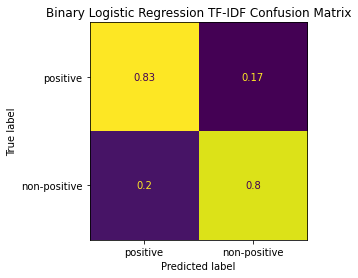

In [88]:
# split the independent and dependent variables
XBinary = binarySentTrain['text']
yBinary = binarySentTrain['label']

# fit and transform the text with the tokenizers
XBinaryIdf = sentWordsIdf.fit_transform(XBinary)
XBinaryVec = sentWordsVec.fit_transform(XBinary)

# split the data into train and validation sets
XBIdfTrain, XBIdfVal, yBIdfTrain, yBIdfVal = train_test_split(XBinaryIdf, yBinary, test_size = 0.33, random_state = 12)
XBVecTrain, XBVecVal, yBVecTrain, yBVecVal = train_test_split(XBinaryVec, yBinary, test_size = 0.33, random_state = 12)

# compile and fit the logistic regression with the binary idf data
logitBIdf = LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12)
logitBIdf.fit(XBIdfTrain, yBIdfTrain)
# predict the binary idf validation data
logBIdfPreds = logitBIdf.predict(XBIdfVal)

# compile and fit the logistic regression with the binary vec data
logitBVec = LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12)
logitBVec.fit(XBVecTrain, yBVecTrain)
# predict the binary vec validation data
logBVecPreds = logitBVec.predict(XBVecVal)

# print the results
print(f"Binary Logistic Regression Idf Score: {logitBIdf.score(XBIdfVal, yBIdfVal)}")
print(f"Binary Logistic Regression Vec Score: {logitBVec.score(XBVecVal, yBVecVal)}")
print()
print(metrics.classification_report(yBIdfVal, logBIdfPreds, target_names = binarySentTrain['sentiment'].unique()))
print(metrics.classification_report(yBVecVal, logBVecPreds, target_names = binarySentTrain['sentiment'].unique()))

# build and show the confusion matrix
sentiments = ['positive','non-positive']
plt.figure(figsize = (10,5))
plot_confusion_matrix(logitBIdf, XBIdfVal ,yBIdfVal, colorbar = False, display_labels = sentiments, normalize = 'true')
plt.title('Binary Logistic Regression TF-IDF Confusion Matrix')
plt.show()

Right away we can see a significant increase in all of our metrics. The recall is above 80% for both the potential classes with both tokenizers. We used the f1-score as a tie breaker when deciding which tokenized model to selelct where the TF-IDF configuration slightly won out. It seems like we were correct in assuming that the multi-class nature and lack of hard boundaries between those classes was the cause of our issues. Next we will test whether or not we see further improvement if we remove the neutral reviews completely. 

In [89]:
# copy og train dataframe minus the neutral rows
dropSentTrain = sentTrain[sentTrain.sentiment != 'neutral']
# standardize the labels
dropSentTrain['label'].replace({2:1}, inplace = True)
dropSentTrain

,sentiment,text,label
0,positive,good mobile. battery is 5000 mah is very big. ...,1
1,positive,Overall in hand ecpirience is quite good matt ...,1
2,positive,"1. Superb Camera,\r\n2. No lag\r\n3. This is m...",1
3,positive,Bigger size of application names doesn't allow...,1
4,negative,Just a hype of stock android which is not flaw...,0
...,...,...,...
49994,positive,This place is heavenly!!! I have dreams about ...,1
49995,positive,good display..good battery...awsm perfomace..i...,1
49996,negative,bad phone,0
49998,negative,Bakbass phone ever. Camera quality just 2 mp c...,0


Dropped Logistic Regression Idf Score: 0.8709416054169802
Dropped Logistic Regression Vec Score: 0.8612188205335957

              precision    recall  f1-score   support

    positive       0.85      0.90      0.87      8621
    negative       0.89      0.85      0.87      8658

    accuracy                           0.87     17279
   macro avg       0.87      0.87      0.87     17279
weighted avg       0.87      0.87      0.87     17279

              precision    recall  f1-score   support

    positive       0.84      0.90      0.87      8621
    negative       0.89      0.83      0.86      8658

    accuracy                           0.86     17279
   macro avg       0.86      0.86      0.86     17279
weighted avg       0.86      0.86      0.86     17279



<Figure size 720x360 with 0 Axes>

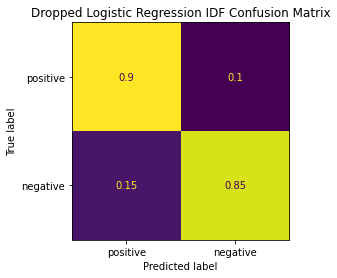

In [90]:
# split the independent and dependent variables
XDrop = dropSentTrain['text']
yDrop = dropSentTrain['label']

# fit and transform the text with the tokenizers
XDropIdf = sentWordsIdf.fit_transform(XDrop)
XDropVec = sentWordsVec.fit_transform(XDrop)

# compile and fit the oversampling function
overSample = SMOTE(random_state = 12)
XDropIdfOS, yDropIdfOS = overSample.fit_resample(XDropIdf, yDrop)
XDropVecOS, yDropVecOS = overSample.fit_resample(XDropVec, yDrop)

# split the data into train and validation sets
XDIdfTrain, XDIdfVal, yDIdfTrain, yDIdfVal = train_test_split(XDropIdfOS, yDropIdfOS, test_size = 0.33, random_state = 12)
XDVecTrain, XDVecVal, yDVecTrain, yDVecVal = train_test_split(XDropVecOS, yDropVecOS, test_size = 0.33, random_state = 12)

# compile and fit the logistic regression with the drop idf data
logitDIdf = LogisticRegression(solver='lbfgs', C = bestCValIdf, random_state = 12)
logitDIdf.fit(XDIdfTrain, yDIdfTrain)
# predict the drop idf validation data
logDIdfPreds = logitDIdf.predict(XDIdfVal)

# compile and fit the logistic regression with the drop vec data
logitDVec = LogisticRegression(solver='lbfgs', C = bestCValVec, random_state = 12)
logitDVec.fit(XDVecTrain, yDVecTrain)
# predict the drop vec validation data
logDVecPreds = logitDVec.predict(XDVecVal)

# print the results
print(f"Dropped Logistic Regression Idf Score: {logitDIdf.score(XDIdfVal, yDIdfVal)}")
print(f"Dropped Logistic Regression Vec Score: {logitDVec.score(XDVecVal, yDVecVal)}")
print()
print(metrics.classification_report(yDIdfVal, logDIdfPreds, target_names = dropSentTrain['sentiment'].unique()))
print(metrics.classification_report(yDVecVal, logDVecPreds, target_names = dropSentTrain['sentiment'].unique()))

# build and show the confusion matrix
sentiments = ['positive','negative']
plt.figure(figsize = (10,5))
plot_confusion_matrix(logitDIdf, XDIdfVal ,yDIdfVal, colorbar = False, display_labels = sentiments, normalize = 'true')
plt.title('Dropped Logistic Regression IDF Confusion Matrix')
plt.show()

Dropped Moultinomial Naive Bayes Idf Score: 0.8532322472365299

              precision    recall  f1-score   support

    positive       0.86      0.85      0.85      8621
    negative       0.85      0.86      0.85      8658

    accuracy                           0.85     17279
   macro avg       0.85      0.85      0.85     17279
weighted avg       0.85      0.85      0.85     17279



<Figure size 720x360 with 0 Axes>

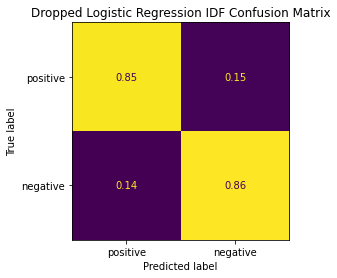

In [94]:
# compile and fit nb model with vec train data
nbDIdf = MultinomialNB().fit(XDIdfTrain, yDIdfTrain)
# predict validation Idf data
nbIdfDropPreds = nbDIdf.predict(XDIdfVal)

# print the results
print(f"Dropped Moultinomial Naive Bayes Idf Score: {nbDIdf.score(XDIdfVal, yDIdfVal)}")
print()
print(metrics.classification_report(yDIdfVal, nbIdfDropPreds, target_names = dropSentTrain['sentiment'].unique()))

# build and show the confusion matrix
sentiments = ['positive','negative']
plt.figure(figsize = (10,5))
plot_confusion_matrix(nbDIdf, XDIdfVal ,yDIdfVal, colorbar = False, display_labels = sentiments, normalize = 'true')
plt.title('Dropped Logistic Regression IDF Confusion Matrix')
plt.show()

After removing the neutral reviews and oversampling the negative reviews to build a balanced data set we have achieved the best scores on all of our metrics throughout this project. Based on the steps that we have taken I am confident that we have found the optimal model and set up to classify reviews with positive and negative sentiments. 

## Production Tool

In our scenario we are assuming that the baseline data that needs to be classified is given in .csv format and contains only text from reviews. The required output is a graph showing the ratio of positive and negative reviews as well as two lists: one for the negative reviews and one for the positive. To test the implementation of our model we'll feed some new data into a function that generates the graph and the two required list. 

Part of the original dataset download included a second dataset with 10,000 reviews for the purpose of testing. We have altered that data set ('generic_sentiment_dataset_10k.csv) by removing all the sentiments and labels as well as the neutral records resulting in a .csv with only text. This is then fed into our production function where it is tokenized, and predicted against our Logistic Regression model with an TF-IDF tokenizer that was trained on the oversampled data with the neutral reviews removed. 

In [97]:
# required imuts are 3 strings: path to the data in csv format, intended name of the negative review list, intended name of the positive review list
def predictText(csvFilePath, negOutputFileName, posOutputFileName):
    # read the data into a dataframe
    dropSentTest = pd.read_csv(csvFilePath)

    # dictionary to categorize the labels
    idToCategory = { 1: 'positive', 0: 'negative'}

    # convert the dataframe to a numpy array
    testText = dropSentTest.to_numpy().ravel()
    # fit the tokenizer on the dropped data
    sentWordsIdf.fit(XDrop)
    # tokenize our test text data 
    testTextTokens = sentWordsIdf.transform(testText).toarray()
    # predict our tokenized test data with our model
    testPreds = logitDIdf.predict(testTextTokens)
    

    # set date variable with today's date
    todayDate = date.today().strftime('%Y%m%d')
    # open/create file for negative output
    predNegDoc = open(negOutputFileName+".txt", "w", encoding = "utf-8")
    # write a line with today's date
    predNegDoc.write(f"Beginning of "+todayDate+" reviews"+"\n")

    # open/create file for positive output
    predPosDoc = open(posOutputFileName+".txt", "w", encoding = "utf-8")
    # write a line with today's date
    predPosDoc.write(f"Beginning of "+todayDate+" reviews"+"\n")

    # zip our test text and the prediction together
    testDataZip = zip(testText, testPreds)
    # loop through the data and write the text and it's prediction to the appropriate list
    for text, predicted in testDataZip:
        # if loop to separate negative and positive reviews
        if predicted == 0:
            # print text body
            predNegDoc.write('"{}"'.format(text)+"\n")
            # print predictive category
            predNegDoc.write("  - Predicted as: '{}'".format(idToCategory[predicted])+"\n")
            # print line to improve readability
            predNegDoc.write("---------------------------------------------------------------------------------------\n")
        else:
            # print text body
            predPosDoc.write('"{}"'.format(text)+"\n")
            # print predictive category
            predPosDoc.write("  - Predicted as: '{}'".format(idToCategory[predicted])+"\n")
            # print line to improve readability
            predPosDoc.write("---------------------------------------------------------------------------------------\n")

    # print date at end of list
    predNegDoc.write(f"End of "+todayDate+" reviews\n")
    # close list file
    predNegDoc.close()

    # print date at end of list
    predPosDoc.write(f"End of "+todayDate+" reviews\n")
    # close list file
    predPosDoc.close()

    # get the counts of the predicted classes of the test data
    predValues, predCounts = np.unique(testPreds, return_counts = True)
    # pie plot of the classes and their normalized counts
    total = len(predCounts)
    plt.figure(figsize = (10,5))
    plt.pie(predCounts, explode = (0, 0.05), labels = ['negative', 'positive'], autopct='%1.2f%%', radius = 3, labeldistance = -0.5, textprops={'fontsize': 14, 'backgroundcolor': 'w', 'weight': 'bold'})
    plt.show()

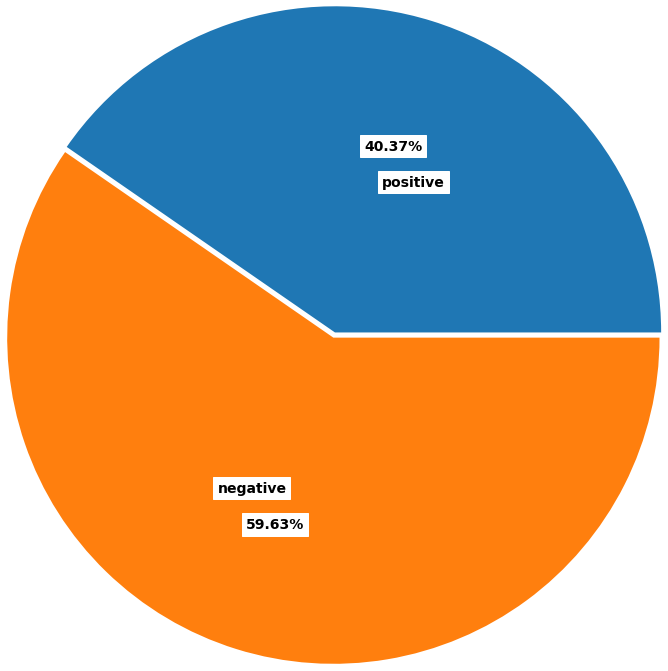

In [98]:
# run output function
predictText('testTextDataDrop.csv','negReviewList', 'posReviewList')

In [93]:
# load in original test data
ogTestDataDrop = pd.read_csv('generic_sentiment_dataset_10k.csv')
# drop neutral records
ogTestDataDrop = ogTestDataDrop[ogTestDataDrop.sentiment != 'neutral']
# rename labels
ogTestDataDrop['label'].replace({2:1}, inplace = True)
print(f"Predicted counts\npositive    {round(8023*0.4037,)}\nnegative    {round(8023*0.5963,)}\n")
# count true classifications
print("True counts")
print(ogTestDataDrop['sentiment'].value_counts(normalize = False))

Predicted counts
positive    3239
negative    4784

True counts
positive    5241
negative    2782
Name: sentiment, dtype: int64


## Conclusions

Based on the true values of the test data set we can see that there is roughly 25% of the positive data that is being classified as negative. This is not within the arbitrary goals of the project and does not foster confidence in the model to effectively categorize this data. I believe that this project was thorough in its model selection and optimization as well as exploring different data manipulations to get the best results with this dataset. This project trained it's models using only ~1650 tokens which is likely too little to be able to decode portions of an entire language. The number of tokens could easily be increased by reducing the minimum document frequency within the tokenizer parameters that we used. This issue with simply doing that to increase the number of token the model is trained on is that it would lead to more over-fitting and not necessarily improve it's performance when predicting on new data. More complicated models, like neural networks, could also be applied but they would also suffer from the size and breadth of our current dataset. In summary we believe that to build an Natural Language Processing model for the purposes of sentiment analysis is it important that your training dataset be very large. This would ensure that your model is training off of a diverse yet specific vocabulary and have the ability to effectively predict text that it was not trained on.